In [1]:
%pip install spark-nlp==6.0.2 numpy pandas matplotlib seaborn setuptools wordcloud
%pip install --upgrade setuptools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import findspark
findspark.init('./spark/spark-3.5.1-bin-hadoop3')
from pyspark import *
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DateType, TimestampType, LongType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DecimalType
from pyspark.sql.functions import regexp_extract, split, from_unixtime, col, avg, min, max
from pyspark.sql.functions import grouping_id, window, explode, to_json, from_json
from pyspark.sql.functions import udf, lit, current_timestamp, current_date, date_format

In [3]:
spark = SparkSession.builder \
    .appName("kafkademo") \
    .config("spark.jars.packages", 
            ",".join([
                "com.johnsnowlabs.nlp:spark-nlp_2.12:6.0.2"
            ])) \
    .getOrCreate()

25/07/27 15:22:10 WARN Utils: Your hostname, Joses-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.105.113.167 instead (on interface en0)
25/07/27 15:22:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/joseaguilar/Documents/Development/spark/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/joseaguilar/.ivy2/cache
The jars for the packages stored in: /Users/joseaguilar/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b7fc2216-bd04-4570-99bc-c035079cdae2;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.0.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in local-m2-cache
	found org.apache.httpcomponents#httpclient;4.5.13 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.13 in local-m2-cache
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws

In [4]:

print(spark.version)
import sys
print(sys.version)
spark.sql("select version()").show();

3.5.1
3.9.21 (main, Dec  3 2024, 17:50:13) 
[Clang 16.0.0 (clang-1600.0.26.4)]
+--------------------+
|           version()|
+--------------------+
|3.5.1 fd86f85e181...|
+--------------------+



In [5]:
import sparknlp
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer

print(sparknlp.version())
spark = sparknlp.start()

6.0.2


25/07/27 15:22:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# Cargar el archivo de texto en un DataFrame de Spark
df_texto = spark.read.text("/Users/joseaguilar/Documents/Development/databricks/spark_databricks/programa.txt").toDF("linea_texto")
df_texto.show(5)

+--------------------+
|         linea_texto|
+--------------------+
|                    |
|BCD-8216 Datos Ma...|
|Profesor: Jose Al...|
|Correo: jose.agui...|
|Horario de atenci...|
+--------------------+
only showing top 5 rows



In [7]:
# Configurar una pipeline de Spark NLP para tokenizar
document_assembler = DocumentAssembler()\
    .setInputCol("linea_texto").setOutputCol("document")
tokenizer = Tokenizer()\
    .setInputCols(["document"]).setOutputCol("token")
# Opcional: normalizador para eliminar puntuación y convertir a minúsculas
normalizer = Normalizer()\
    .setInputCols(["token"]).setOutputCol("token_norm")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\\w¿?¡!áéíóúÁÉÍÓÚüÜñÑ]"])  # quitar símbolos no deseados

finisher = Finisher()\
    .setInputCols(["token_norm"]).setOutputCols(["palabras"])\
    .setCleanAnnotations(False)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[document_assembler, tokenizer, normalizer, finisher])
modelo = pipeline.fit(df_texto)
df_tokens = modelo.transform(df_texto).select("palabras")  # columna con lista de tokens
df_tokens.show(5, truncate=False)

+--------------------------------------------------------------------------------------+
|palabras                                                                              |
+--------------------------------------------------------------------------------------+
|[]                                                                                    |
|[bcd8216, datos, masivos]                                                             |
|[profesor, jose, alberto, aguilar]                                                    |
|[correo, joseaguilarruleadaccr]                                                       |
|[horario, de, atención, al, estudiante, viernes, 600, pm, 700, pm, con, cita, virtual]|
+--------------------------------------------------------------------------------------+
only showing top 5 rows



In [8]:
# Explode de la columna de listas de palabras para tener una palabra por fila
from pyspark.sql.functions import explode, col
df_palabras = df_tokens.select(explode(col("palabras")).alias("palabra"))
# Filtrar posibles tokens vacíos o muy cortos si aplica
df_palabras = df_palabras.filter(col("palabra") != "")

# Contar frecuencia de cada palabra
df_freq = df_palabras.groupBy("palabra").count().orderBy(col("count").desc())
df_freq.show(10)

+-------+-----+
|palabra|count|
+-------+-----+
|     de|  346|
|      y|  129|
|     la|  112|
|     en|   91|
|    del|   91|
|  datos|   89|
|   data|   86|
|     el|   75|
|    los|   75|
|      a|   70|
+-------+-----+
only showing top 10 rows



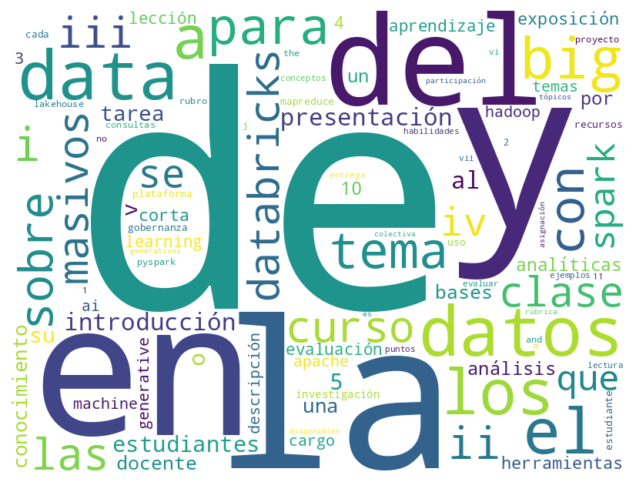

In [9]:
# Recopilar las palabras más frecuentes en Pandas para visualización
top_words = df_freq.limit(100).toPandas()  # top 100 palabras
palabras = top_words['palabra'].values
frecuencias = top_words['count'].values

# Crear la nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=600, background_color="white", colormap="viridis")
freqs_dict = {palabra: int(freq) for palabra, freq in zip(palabras, frecuencias)}
wc.generate_from_frequencies(freqs_dict)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
